In [1]:
# Mount Google Drive to access dataset files
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# Define paths to the training, validation, and test datasets
train_folder = '/content/drive/MyDrive/dataset/train'
test_folder = '/content/drive/MyDrive/dataset/test'
validate_folder = '/content/drive/MyDrive/dataset/valid'

# Define paths to the specific classes within the dataset
normal_folder = '/normal'
adenocarcinoma_folder = '/adenocarcinoma'
large_cell_carcinoma_folder = '/large.cell.carcinoma'
squamous_cell_carcinoma_folder = '/squamous.cell.carcinoma'


In [3]:
# Import necessary libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
import tensorflow.keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SpatialDropout2D, Activation, Lambda, Flatten, LSTM
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import utils

print("Libraries Imported")

# Set the image size for resizing
IMAGE_SIZE = (350, 350)

# Initialize the image data generators for training and testing
print("Reading training images from:", train_folder)
print("Reading validation images from:", validate_folder)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)


# Define the batch size for training
batch_size = 8


# Create the training data generator
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


# Create the validation data generator
validation_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    color_mode="rgb",
    class_mode='categorical'
)


Libraries Imported
Reading training images from: /content/drive/MyDrive/dataset/train
Reading validation images from: /content/drive/MyDrive/dataset/valid
Found 612 images belonging to 4 classes.
Found 315 images belonging to 4 classes.


In [ ]:
# Set up callbacks for learning rate reduction, early stopping, and model checkpointing
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

learning_rate_reduction = ReduceLROnPlateau(monitor='loss', patience=5, verbose=2, factor=0.5, min_lr=0.000001)
early_stops = EarlyStopping(monitor='loss', min_delta=0, patience=6, verbose=2, mode='auto')
checkpointer = ModelCheckpoint(
    filepath='best_model.weights.h5',  # Updated file extension
    verbose=2,
    save_best_only=True,
    save_weights_only=True
)



In [5]:
# Define the number of output classes
OUTPUT_SIZE = 4

# Load a pre-trained model (Xception) without the top layers and freeze its weights
pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False, input_shape=[*IMAGE_SIZE, 3])
pretrained_model.trainable = False

for layer in pretrained_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Create a new model with the pre-trained base and additional layers for classification
model = Sequential()
model.add(pretrained_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))  # Add dropout layer
model.add(Dense(OUTPUT_SIZE, activation='softmax'))

print("Pretrained model used:")
pretrained_model.summary()

print("Final model created:")
model.summary()

# Compile the model with an optimizer, loss function, and evaluation metric
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Pretrained model used:


Model: "xception"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 350, 350, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 174, 174, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 174, 174, 32)   │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 174, 174, 32)   │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 172, 172, 64)   │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 172, 172, 64)   │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 172, 172, 64)   │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 172, 172, 128)  │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 172, 172, 128)  │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 172, 172, 128)  │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 172, 172, 128)  │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 86, 86, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 86, 86, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization  

 Total params: 20,861,480 (79.58 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,861,480 (79.58 MB)

Final model created:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ xception (Functional)                │ (None, 11, 11, 2048)        │      20,861,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           8,196 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,869,676 (79.61 MB)

 Trainable params: 8,948,548 (34.14 MB)

 Non-trainable params: 11,921,128 (45.48 MB)

In [7]:
# Train the model with the training and validation data generators
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    callbacks=[learning_rate_reduction,early_stops, checkpointer],
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size
)


print("Final training accuracy =", history.history['accuracy'][-1])
print("Final testing accuracy =", history.history['val_accuracy'][-1])


Epoch 1/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5142 - loss: 1.0353
Epoch 1: val_loss improved from inf to 1.23570, saving model to best_model.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 305s 4s/step - accuracy: 0.5154 - loss: 1.0333 - val_accuracy: 0.6442 - val_loss: 1.2357 - learning_rate: 0.0010
Epoch 2/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 10s 139ms/step - accuracy: 0.6250 - loss: 0.7124
Epoch 2: val_loss did not improve from 1.23570
76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.6250 - loss: 0.7124 - val_accuracy: 0.6314 - val_loss: 1.4212 - learning_rate: 0.0010
Epoch 3/50
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step - accuracy: 0.8042 - loss: 0.5438
Epoch 3: val_loss did not improve from 1.23570
76/76 ━━━━━━━━━━━━━━━━━━━━ 47s 328ms/step - accuracy: 0.8042 - loss: 0.5434 - val_accuracy: 0.6282 - val_loss: 1.4052 - learning_rate: 0.0010
Epoch 4/50
 1/76 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.7500 - loss: 0.6267
Epoch 4: val_loss did not improve from 1.23570
76/76 ━━━━

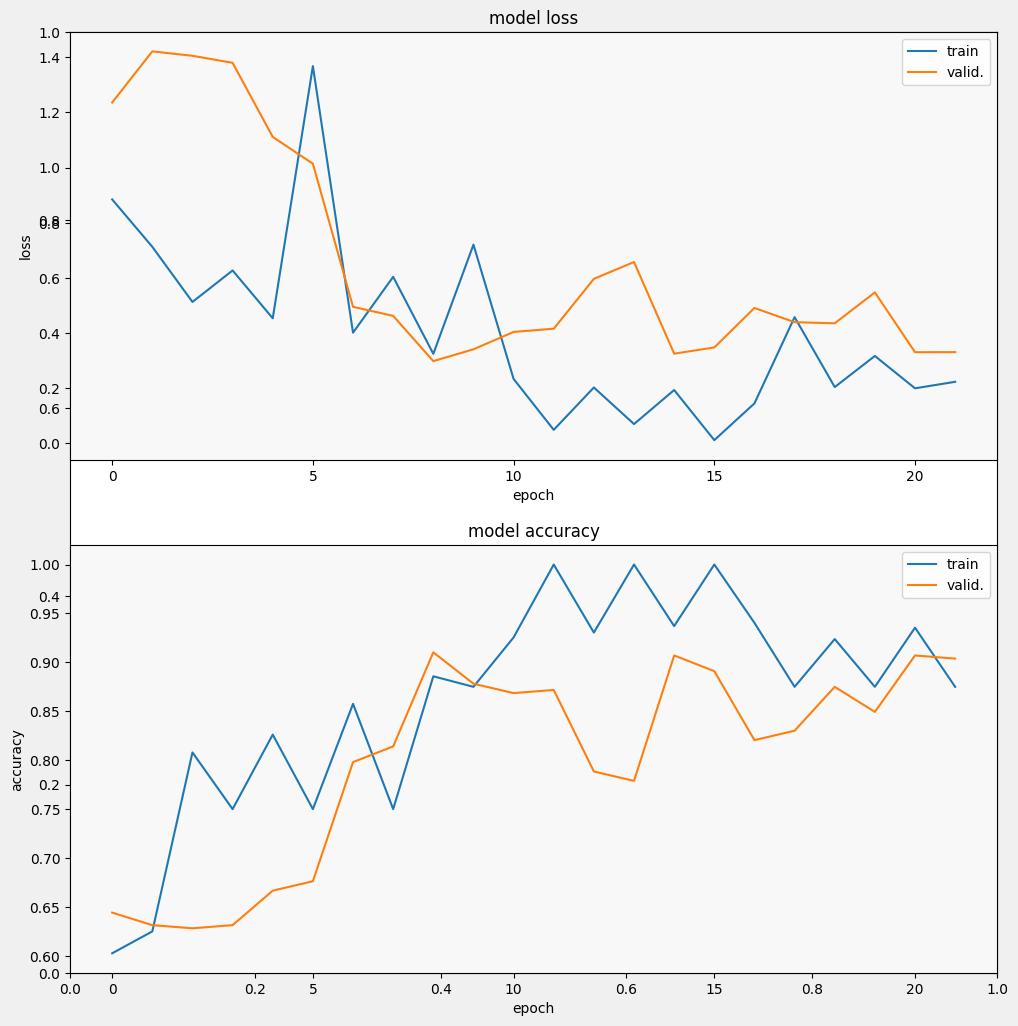

In [9]:
# Function to display training curves for loss and accuracy
def display_training_curves(training, validation, title, subplot):
    if subplot % 10 == 1:
        plt.subplots(figsize=(10, 10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model ' + title)
    ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Display training curves for loss and accuracy
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 211)
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 212)


In [ ]:
# Save the trained model
model.save('/content/drive/MyDrive/dataset/90Accuracy.h5')


In [12]:
# prompt: save the model useing pickle

import pickle

# Save the model using pickle
with open('/content/drive/MyDrive/dataset/90%.pkl', 'wb') as f:
    pickle.dump(model, f)